In [1]:
!pip install matplotlib deap

     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     ----- ---------------------------------- 0.1/1.1 MB 1.7 MB/s eta 0:00:01
     ----------------------------------- ---- 0.9/1.1 MB 7.5 MB/s eta 0:00:01
     ---------------------------------------- 1.1/1.1 MB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for deap: filename=deap-1.4.1-py3-none-any.whl size=97348 sha256=8601e2965463fdd8d77276eb419de623340f187e0964ba58ec66b65ab9b70f1f
  Stored in directory: c:\users\win 10\appdata\local\pip\cache\wheels\f8\64\b8\65eacfbff3024ae2e2beb22e691d5c8abb89fbd863b8049b5f
Successfully built deap


In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

In [3]:
# Define the maze
maze = [
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
]

# Start and end points
start, end = (0, 0), (len(maze)-1, len(maze[0])-1)

In [4]:
# Genetic Algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_direction", random.choice, ['U', 'D', 'L', 'R'])
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_direction, n=100)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [5]:
def evaluate(individual):
    x, y = start
    for move in individual:
        # Move up, down, left, or right while checking boundaries
        if move == 'U': y = max(0, y - 1)
        elif move == 'D': y = min(len(maze) - 1, y + 1)
        elif move == 'L': x = max(0, x - 1)
        elif move == 'R': x = min(len(maze[0]) - 1, x + 1)

        # Check if the current position is the end goal
        if (x, y) == end:
            return (0,)  # Perfect score since we reached the end

        # Check if the current position is a wall
        if maze[y][x] == 1:
            break

    # Return the Manhattan distance to the end point as the score
    return (abs(end[0] - x) + abs(end[1] - y),)

In [6]:
def custom_mutate(individual, indpb=0.2):
    directions = ['U', 'D', 'L', 'R']
    for i in range(len(individual)):
        if random.random() < indpb:
            # Exclude the current direction to ensure mutation changes the gene
            possible_directions = [d for d in directions if d != individual[i]]
            individual[i] = random.choice(possible_directions)
    return individual,

In [7]:
toolbox.register("evaluate", evaluate)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", custom_mutate, indpb=0.2)

In [8]:
# Function to visualize the maze and path
def plot_path(individual):
    x, y = start
    plt.plot(x, y, "go")  # start point
    for move in individual:
        # Attempt the move
        next_x, next_y = x, y
        if move == 'U': next_y = max(0, y - 1)
        elif move == 'D': next_y = min(len(maze) - 1, y + 1)
        elif move == 'L': next_x = max(0, x - 1)
        elif move == 'R': next_x = min(len(maze[0]) - 1, x + 1)

        # Check for wall collision before plotting the move
        if maze[next_y][next_x] == 1 or (next_x, next_y) == end: break
        # No collision, so make the move and plot it
        x, y = next_x, next_y
        # plt.plot(x, y, "bo")

    plt.plot(end[0], end[1], "ro")  # end point
    plt.imshow(maze, cmap="binary")
    plt.show()

In [9]:
# Run the genetic algorithm
def run_ga(generations=2000, pop_size=50):
    pop = toolbox.population(n=pop_size)
    best_individuals = []
    for gen in range(generations):
        offspring = algorithms.varAnd(pop, toolbox, cxpb=0.5, mutpb=0.2)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
        pop = toolbox.select(offspring, k=len(pop))
        top_individual = tools.selBest(pop, k=1)[0]
        best_individuals.append(top_individual)

        if gen in [2, 10, 50, 100, 500] or gen == generations - 1:
            print(f"Generation {gen}:")
            plot_path(top_individual)

Generation 2:


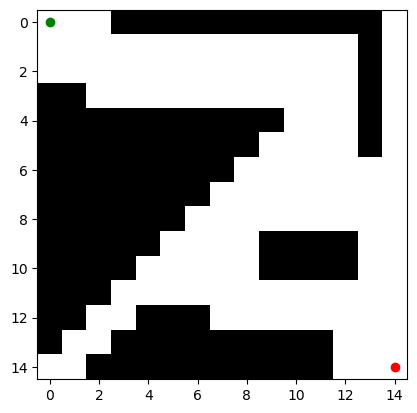

Generation 10:


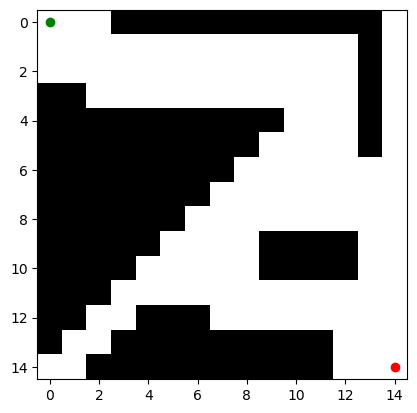

Generation 50:


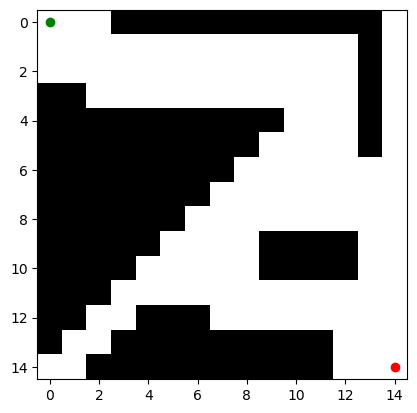

Generation 100:


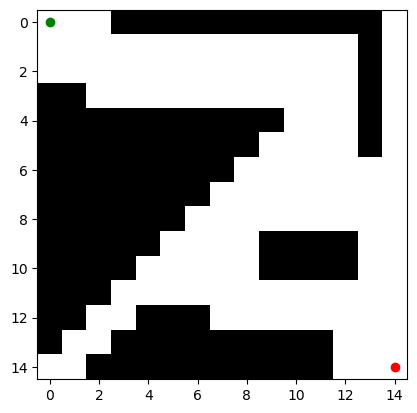

Generation 500:


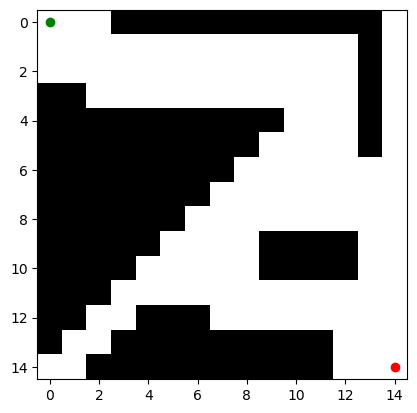

Generation 1999:


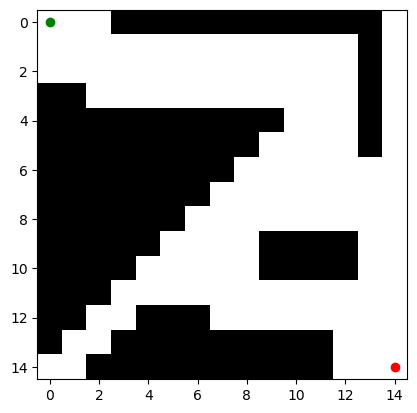

In [10]:
run_ga()